<a href="https://colab.research.google.com/github/AbdulrahmanAbdulqawi/AbdulrahmanAbdulqawi.github.io/blob/main/Or%20Gate%20With%20Four%20Lines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.parameter import Parameter

In [2]:
def gen_data(num_samples, noise=7):
  points = []
  labels = []

  for i in range(num_samples):
    x = np.random.uniform()
    y = np.random.uniform()

    nx = np.random.uniform(low=-noise/1000, high=noise/1000)
    ny = np.random.uniform(low=-noise/1000, high=noise/1000)


    if(7.7*x-2.0 < 0 or 7.7*x-3.5>0 or -0.3*x-y +0.5 > 0 or -0.3*x-y +0.8 < 0  ):
        if noise > 0:
            points.append([x+nx, y+ny, 0])
            labels.append(0)
        else:
            points.append([x, y, 0])
            labels.append(0)
    else:
        if noise > 0:
            points.append([x+nx, y+ny, 1])
            labels.append(1)
        else:
            points.append([x, y, 1])
            labels.append(1)

  return points, labels

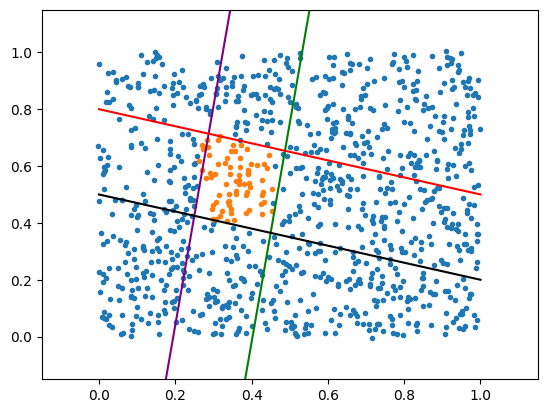

In [4]:
points, labels = gen_data(1000, 7)


plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

# plot lines
x = torch.linspace(0, 1, steps=100)


plt.plot(x, (7.7*x-3.1), 'green')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0
plt.plot(x, (7.7*x-1.5), 'purple')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0
plt.plot(x, (-0.3*x+0.5), 'black')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0
plt.plot(x, (-0.3*x+0.8), 'red')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0
plt.ylim(-0.15, 1.15)
plt.xlim(-0.15, 1.15)
plt.show()

In [5]:

class SquashingFunction(nn.Module):
    '''
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Examples:
        m = squashing(beta=25)
        input = torch.randn(2)
        output = m(input)

        Input/Output have same shape:
        input.shape
        output.shape
    '''
    def __init__(self,learnable=True, beta=0.1):
        '''
        Init method.
        '''
        super(SquashingFunction, self).__init__()

        self.alpha = 0.5
        self.lam = 1.0

        if learnable:
            # initialize beta as learnable parameter
            self.beta = Parameter(torch.tensor(beta))
            self.beta.requiresGrad = True
        else:
            # static value
            self.beta = torch.tensor(beta)
            self.beta.requiresGrad = False



    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta:", self.beta.data.item())
        # define beta global for pandas print
        global betas
        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )

In [6]:
trainX = torch.Tensor([[i[0],i[1]] for i in points]).float()
trainY = torch.Tensor([[i[2]] for i in points]).float()

In [7]:
class SimpleNetwork(nn.Module):
    def __init__(self ,activation = 'squashing'):
        super(SimpleNetwork, self).__init__()

        #Creating the neurons
        self.n1 = nn.Linear(2, 1)
        self.n2 = nn.Linear(2, 1)
        self.n3 = nn.Linear(2, 1)
        self.n4 = nn.Linear(2, 1)

        #Testing with different activaion functions
        if activation == 'relu':
            print("relu")
            self.activation_n1 = nn.ReLU()
            self.activation_n2 = nn.ReLU()
            self.activation_n3 = nn.ReLU()
            self.activation_n4 = nn.ReLU()
            self.activation_or = nn.ReLU()

        elif activation == 'sigmoid':
            print("sigmoid")
            self.activation_n1 = nn.Sigmoid()
            self.activation_n2 = nn.Sigmoid()
            self.activation_n3 = nn.Sigmoid()
            self.activation_n4 = nn.Sigmoid()
            self.activation_or = nn.Sigmoid()

        elif activation == 'tanh':
            print("tanh")
            self.activation_n1 = nn.Tanh()
            self.activation_n2 = nn.Tanh()
            self.activation_n3 = nn.Tanh()
            self.activation_n4 = nn.Tanh()
            self.activation_or = nn.Tanh()
        elif activation == 'squashing':
            print("squashing")
            self.activation_n1 = SquashingFunction()
            self.activation_n2 = SquashingFunction()
            self.activation_n3 = SquashingFunction()
            self.activation_n4 = SquashingFunction()
            self.activation_or = SquashingFunction()

        elif (activation == 'squashing-nl'):
            print("squashing-nl")
            self.activation = SquashingFunction()

        # Creating OR Gate 1


        # Creating OR Gate for the output
        self.or_layer_out = nn.Linear(in_features=4, out_features=1)
        self.or_layer_out.weight.requires_grad = False
        self.or_layer_out.bias.requires_grad  = False

        #passing the weights and bias
        with torch.no_grad():
            self.or_layer_out.weight.fill_(1.0)
            self.or_layer_out.bias.fill_(0.0)

    def forward(self, X):
        global beta_or
        global beta_n1
        global beta_n2
        global beta_n3
        global beta_n4
        global beta_gerade

        self.z1 = self.n1(X)
        self.z1 = self.activation_n1(self.z1)      # activation function
        beta_n1 = betas

        self.z2 = self.n2(X)
        self.z2 = self.activation_n2(self.z2)      # activation function
        beta_n2 = betas

        self.z3 = self.n3(X)
        self.z3 = self.activation_n3(self.z3)      # activation function
        beta_n3 = betas

        self.z4 = self.n4(X)
        self.z4 = self.activation_n4(self.z4)      # activation function
        beta_n4 = betas

        beta_gerade = betas


        self.out = self.or_layer_out(torch.cat((self.z1, self.z2,self.z3,self.z4), 1))
        self.out = self.activation_or(self.out)
        beta_or = betas

        return self.out


squashing
  Loss: 0.2820497453212738
Beta-N1: 0.10000000149011612
Beta-N2: 0.10000000149011612
Beta-N3: 0.10000000149011612
Beta-N4: 0.10000000149011612
Beta-OR: 0.10000000149011612


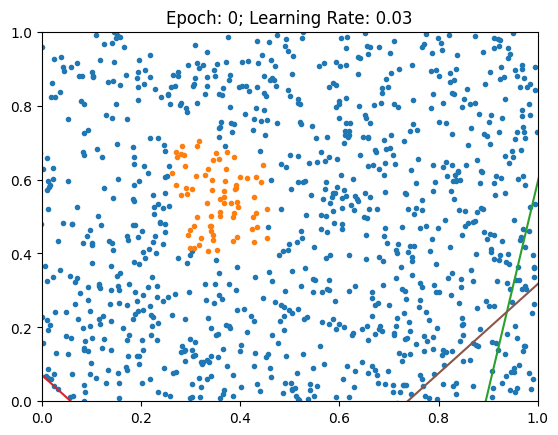

  Loss: 0.06678807735443115
Beta-N1: -0.7710057497024536
Beta-N2: 0.8548597097396851
Beta-N3: -0.8465020060539246
Beta-N4: -0.7985778450965881
Beta-OR: -0.991394579410553


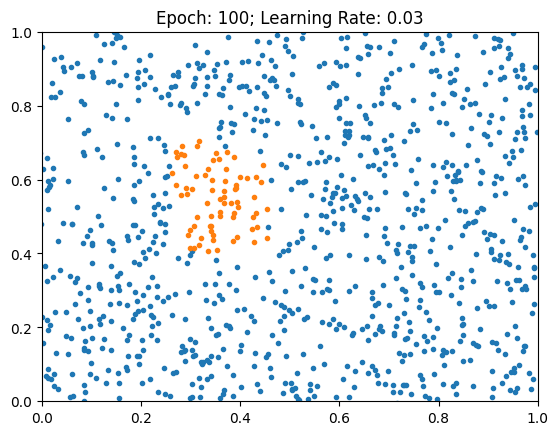

  Loss: 0.06600800156593323
Beta-N1: -0.8371561169624329
Beta-N2: 0.8535658717155457
Beta-N3: -0.8341379165649414
Beta-N4: -0.8026065230369568
Beta-OR: -1.001685380935669


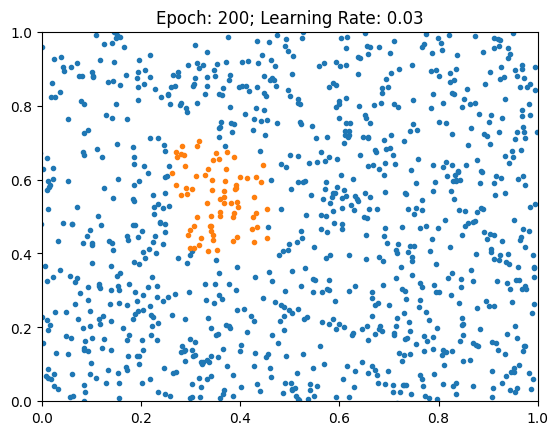

  Loss: 0.06553444266319275
Beta-N1: -0.8982698321342468
Beta-N2: 1.2379310131072998
Beta-N3: -0.8816468119621277
Beta-N4: -0.887816309928894
Beta-OR: -1.0493993759155273


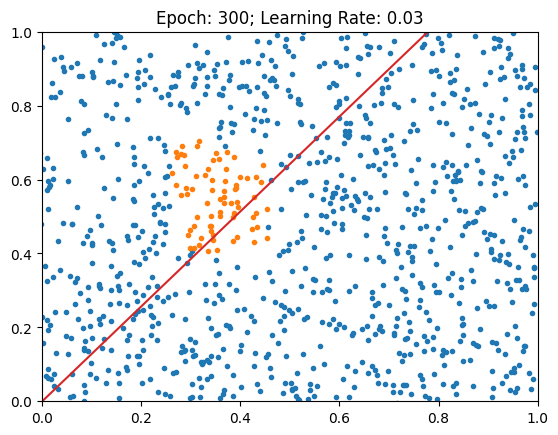

  Loss: 0.06389578431844711
Beta-N1: -0.7553606629371643
Beta-N2: 2.4952852725982666
Beta-N3: -0.844100296497345
Beta-N4: -0.8340554237365723
Beta-OR: -1.0975708961486816


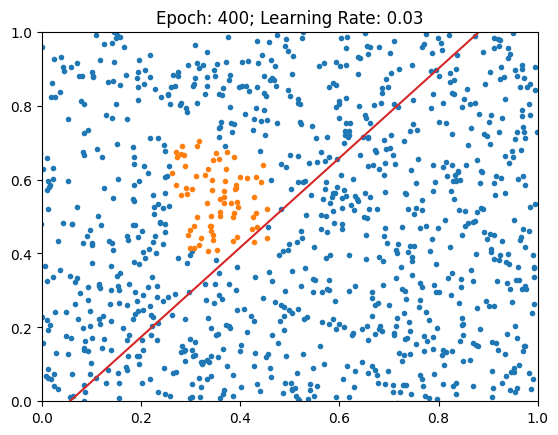

  Loss: 0.06300842016935349
Beta-N1: -0.5297962427139282
Beta-N2: 3.3839714527130127
Beta-N3: -0.7471507787704468
Beta-N4: -0.694484531879425
Beta-OR: -1.169547438621521


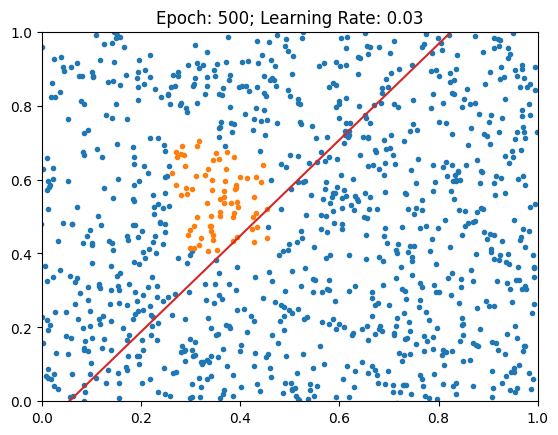

  Loss: 0.06245701014995575
Beta-N1: -0.3704051971435547
Beta-N2: 3.9739701747894287
Beta-N3: -0.6683691143989563
Beta-N4: -0.5832181572914124
Beta-OR: -1.2781352996826172


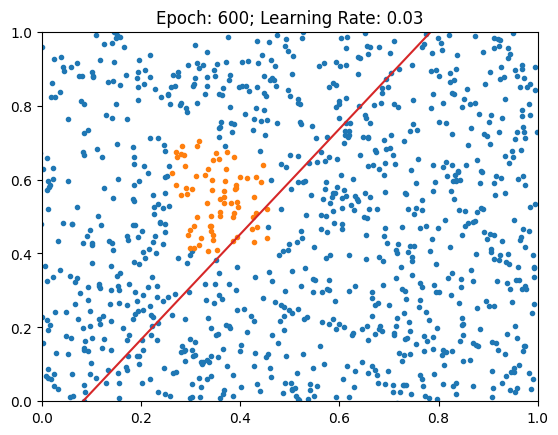

  Loss: 0.06192745268344879
Beta-N1: -0.2812548279762268
Beta-N2: 4.429864883422852
Beta-N3: -0.6157708168029785
Beta-N4: -0.5228408575057983
Beta-OR: -1.4115171432495117


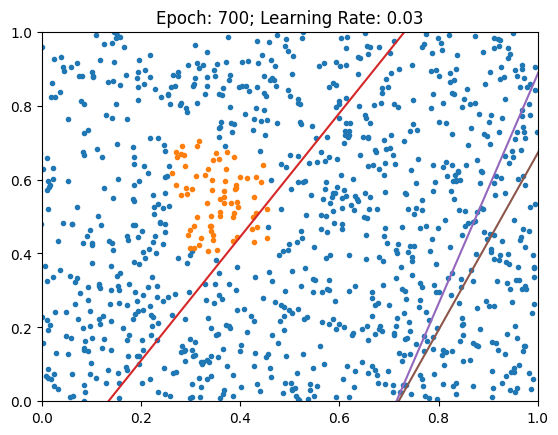

  Loss: 0.06124356389045715
Beta-N1: -0.31058764457702637
Beta-N2: 4.829274654388428
Beta-N3: -0.6450394988059998
Beta-N4: -0.5747203230857849
Beta-OR: -1.5766876935958862


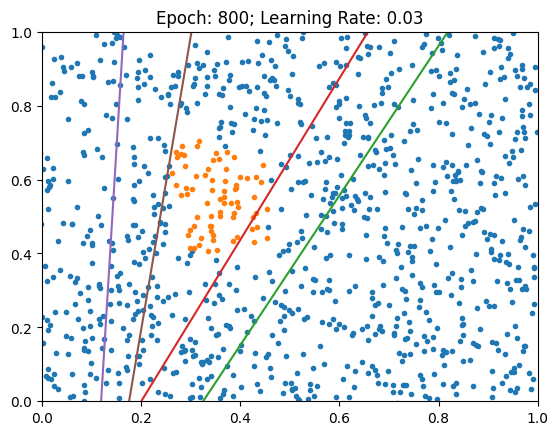

  Loss: 0.059776533395051956
Beta-N1: -0.4767325222492218
Beta-N2: 5.220951080322266
Beta-N3: -1.072401523590088
Beta-N4: -0.5948249697685242
Beta-OR: -1.8174172639846802


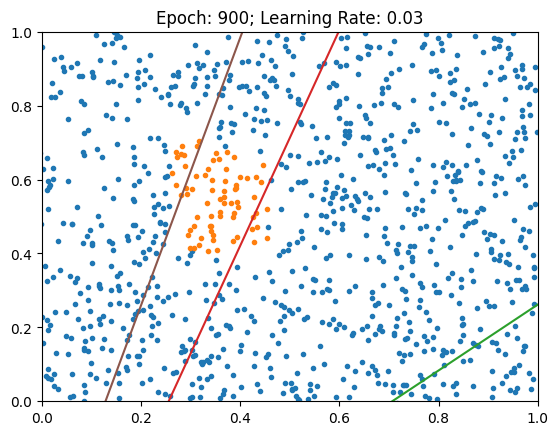

  Loss: 0.05004234239459038
Beta-N1: -0.2644396424293518
Beta-N2: 5.6050591468811035
Beta-N3: -3.571348190307617
Beta-N4: -0.9980770349502563
Beta-OR: -2.151902914047241


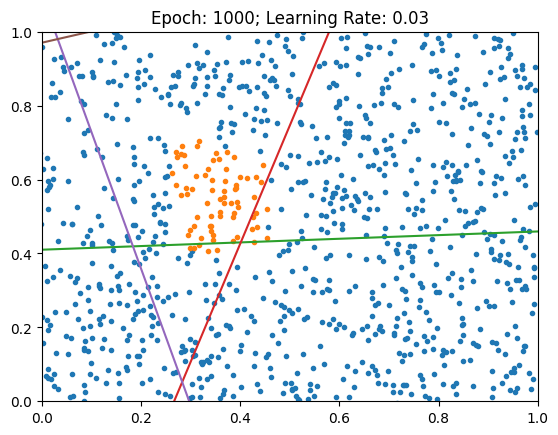

  Loss: 0.026002302765846252
Beta-N1: 0.958082914352417
Beta-N2: 5.950742244720459
Beta-N3: -4.90214204788208
Beta-N4: -4.747384548187256
Beta-OR: -3.001331090927124


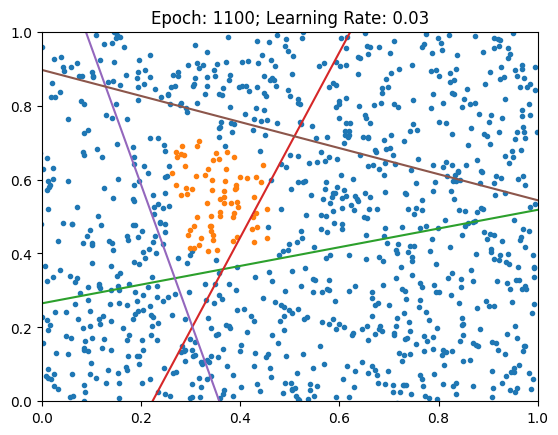

  Loss: 0.01682467944920063
Beta-N1: 3.5245018005371094
Beta-N2: 6.0626935958862305
Beta-N3: -5.6825056076049805
Beta-N4: -5.635979175567627
Beta-OR: -3.6614341735839844


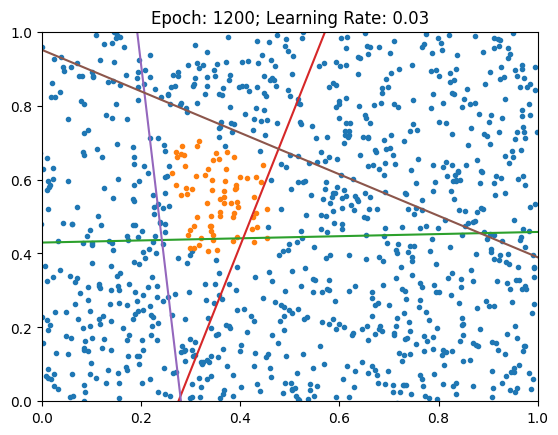

  Loss: 0.013585691340267658
Beta-N1: 4.634461879730225
Beta-N2: 6.1563897132873535
Beta-N3: -6.202518463134766
Beta-N4: -6.108086109161377
Beta-OR: -4.127771377563477


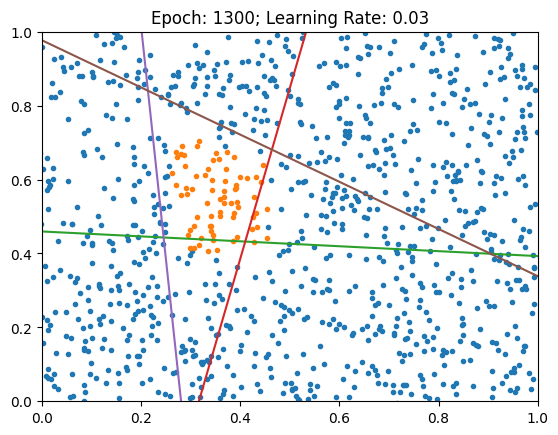

  Loss: 0.011754822917282581
Beta-N1: 5.245599269866943
Beta-N2: 6.258150577545166
Beta-N3: -6.597334861755371
Beta-N4: -6.447779655456543
Beta-OR: -4.516941070556641


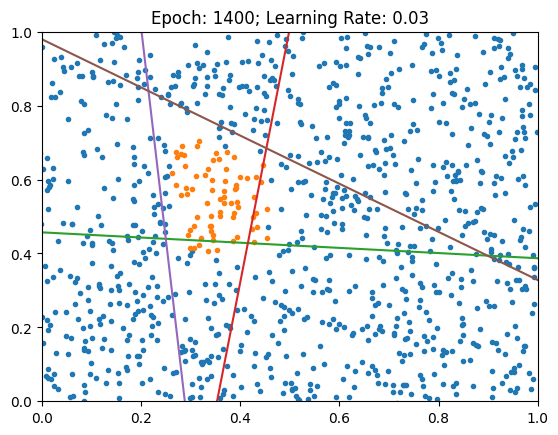

  Loss: 0.010490376502275467
Beta-N1: 5.684256076812744
Beta-N2: 6.386466026306152
Beta-N3: -6.919361591339111
Beta-N4: -6.717825889587402
Beta-OR: -4.855953216552734


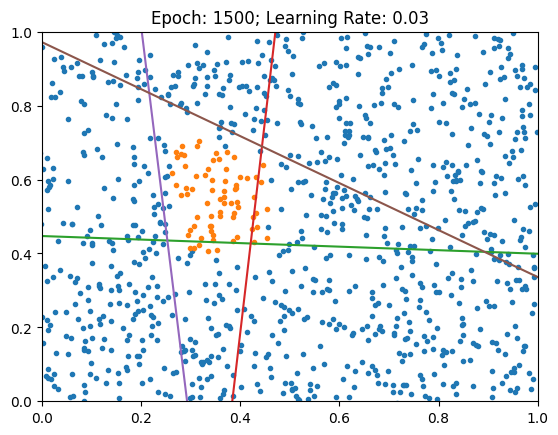

  Loss: 0.00953805260360241
Beta-N1: 6.026324272155762
Beta-N2: 6.574539661407471
Beta-N3: -7.196977138519287
Beta-N4: -6.935375213623047
Beta-OR: -5.159056663513184


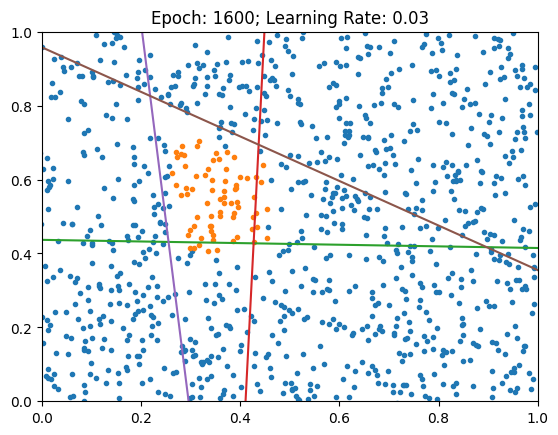

  Loss: 0.008808836340904236
Beta-N1: 6.305886745452881
Beta-N2: 6.790933132171631
Beta-N3: -7.444050312042236
Beta-N4: -7.10793399810791
Beta-OR: -5.435911178588867


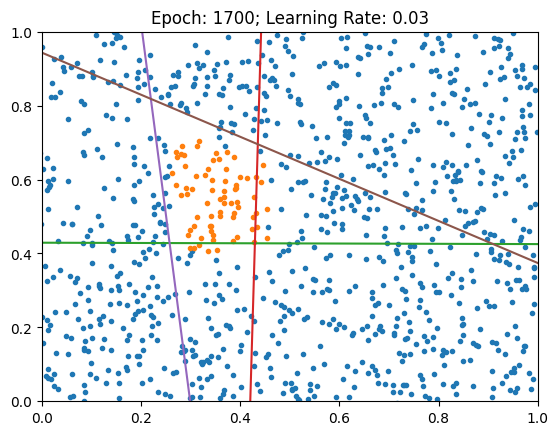

  Loss: 0.00822823029011488
Beta-N1: 6.547396183013916
Beta-N2: 6.998154163360596
Beta-N3: -7.667118549346924
Beta-N4: -7.2479567527771
Beta-OR: -5.693264007568359


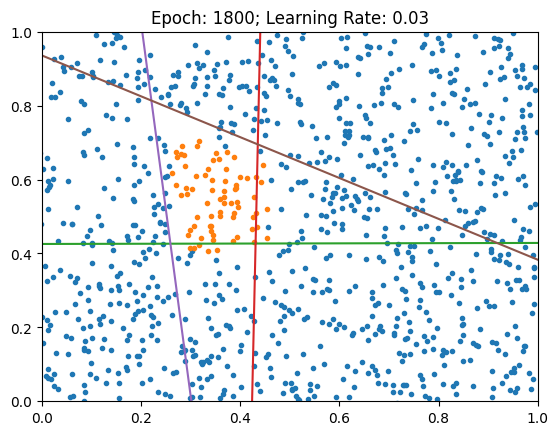

  Loss: 0.007748176343739033
Beta-N1: 6.762514591217041
Beta-N2: 7.192458629608154
Beta-N3: -7.871131896972656
Beta-N4: -7.36808443069458
Beta-OR: -5.935210227966309


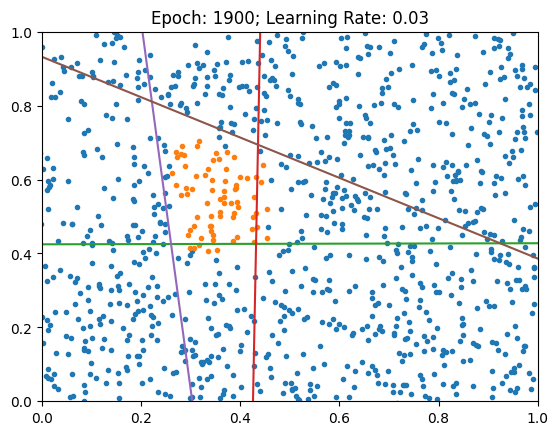

In [10]:
learning_rate = 0.03
network = SimpleNetwork()
optimizer = optim.Adam(network.parameters(),learning_rate)
criterion = nn.MSELoss()

x = torch.linspace(-3,3,steps=100)

beta_n1_arr = []
beta_n2_arr = []
beta_n3_arr = []
beta_n4_arr = []

beta_gerade_arr = []

beta_or_arr = []
loss_arr = []
running_loss =0

for epoch in range(2000):
    preds = network(trainX)
    #print(preds)
    loss = criterion(preds, trainY) # Calculate loss
    optimizer.zero_grad()
    loss.backward() # Calculate Gradient
    optimizer.step() # Update Weights

    beta_n1_arr.append(beta_n1)
    beta_n2_arr.append(beta_n2)
    beta_n3_arr.append(beta_n3)
    beta_n4_arr.append(beta_n4)

    beta_gerade_arr.append(beta_gerade)

    beta_or_arr.append(beta_or)
    loss_arr.append(loss.item())

    running_loss += loss.item()
    if epoch %100 == 0:


        y1 = -((network.n1.weight.squeeze()[0] * x + network.n1.bias[0]) / network.n1.weight.squeeze()[1])
        y2 = -((network.n2.weight.squeeze()[0] * x + network.n2.bias[0]) / network.n2.weight.squeeze()[1])
        y3 = -((network.n3.weight.squeeze()[0] * x + network.n3.bias[0]) / network.n3.weight.squeeze()[1])
        y4 = -((network.n4.weight.squeeze()[0] * x + network.n4.bias[0]) / network.n4.weight.squeeze()[1])

        #y5 = -((network.linear_layer_5.weight.squeeze()[0] * x + network.linear_layer_5.bias[0]) / network.linear_layer_5.weight.squeeze()[1])
        #y6 = -((network.linear_layer_6.weight.squeeze()[0] * x + network.linear_layer_6.bias[0]) / network.linear_layer_6.weight.squeeze()[1])

        #plt.figure(figsize=(12,6))
        plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
        plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

        plt.plot(x.numpy(), y1.detach().numpy(), '-')
        plt.plot(x.numpy(), y2.detach().numpy(), '-')
        plt.plot(x.numpy(), y3.detach().numpy(), '-')
        plt.plot(x.numpy(), y4.detach().numpy(), '-')
        #plt.plot(x.numpy(), y5.detach().numpy(), '-')
        #plt.plot(x.numpy(), y6.detach().numpy(), '-')
        #print("Beta:", betas)
        print(f'  Loss: {loss}')
        print("Beta-N1:", beta_n1)
        print("Beta-N2:", beta_n2)
        print("Beta-N3:", beta_n3)
        print("Beta-N4:", beta_n4)
        print("Beta-OR:", beta_or)
        plt.ylim(0,1)
        plt.xlim(0,1)
        plt.title(f'Epoch: {epoch}; Learning Rate: {learning_rate}')
        plt.show()

<function matplotlib.pyplot.show>

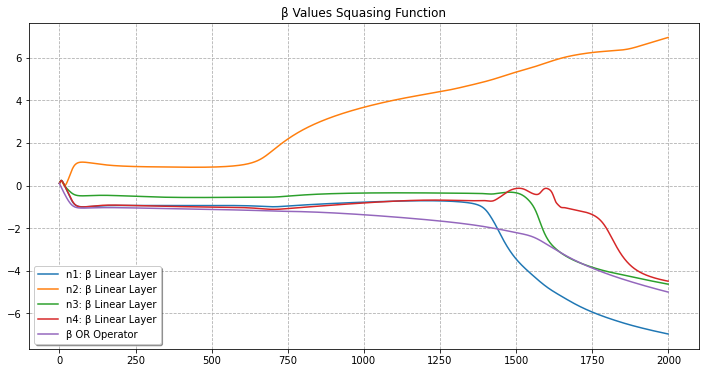

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(beta_n1_arr, label='n1: β Linear Layer')
plt.plot(beta_n2_arr, label='n2: β Linear Layer')
plt.plot(beta_n3_arr, label='n3: β Linear Layer')
plt.plot(beta_n4_arr, label='n4: β Linear Layer')
#plt.plot(beta_gerade_arr, label='ni: β Linear Layer')


plt.plot(beta_or_arr, label='β OR Operator')
plt.legend(loc=2)
plt.grid(True, axis='both', linestyle='--')
plt.title('β Values Squasing Function')
plt.legend(loc='lower left', ncol=1, fancybox=True, shadow=True)
plt.xlabel('Epochs [Train Time]')
# Set the y axis label of the current axis.
plt.ylabel('B Values')
plt.show

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Train Loss Squashing')
plt.plot(loss_arr, label='Loss', color='r')
plt.grid(True, axis='both', linestyle='--')
plt.xlabel('x - axis')
# Set the y axis label of the current axis.
plt.ylabel('y - axis')
plt.show

NameError: ignored

1*0 + 1*0 = 0
1*1 + 1*0 = 1
1*0 + 1*1 = 1
1*1 + 1*1 = 2
